Parsed with column specification:
cols(
  .default = col_integer(),
  `#OTU ID` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  Sample_ID = col_character(),
  Treatment = col_character()
)

Parsed with column specification:
cols(
  `#OTU ID` = col_character(),
  Annotation = col_character()
)



Lineage,Treatment,Abundance,Scaled_abundance
Bacteroidaceae,Cirrhosis,0,-0.2628488
Ruminococcaceae,Cirrhosis,0,-0.2628488
Lachnospiraceae,Cirrhosis,0,-0.2628488
porphyromonadaceae,Cirrhosis,0,-0.2628488
Streptococcaceae,Cirrhosis,1025,-0.2527270
Erysipelotrichaceae,Cirrhosis,0,-0.2628488


Lineage,LOG2FC,abs_LOG2FC,Direction
Acidaminococcaceae,1.97,1.97,Cirrhosis
Actinomycetaceae,1.94,1.94,Cirrhosis
Bacteroidaceae,1.88,1.88,Cirrhosis
Bifidobacteriaceae,0.14,0.14,Cirrhosis
Burkholderiaceae,1.86,1.86,Cirrhosis
Carnobacteriaceae,1.94,1.94,Cirrhosis


[1] "exploratory_feature_abundance common_feature : Family  completed Successfully.!!!"


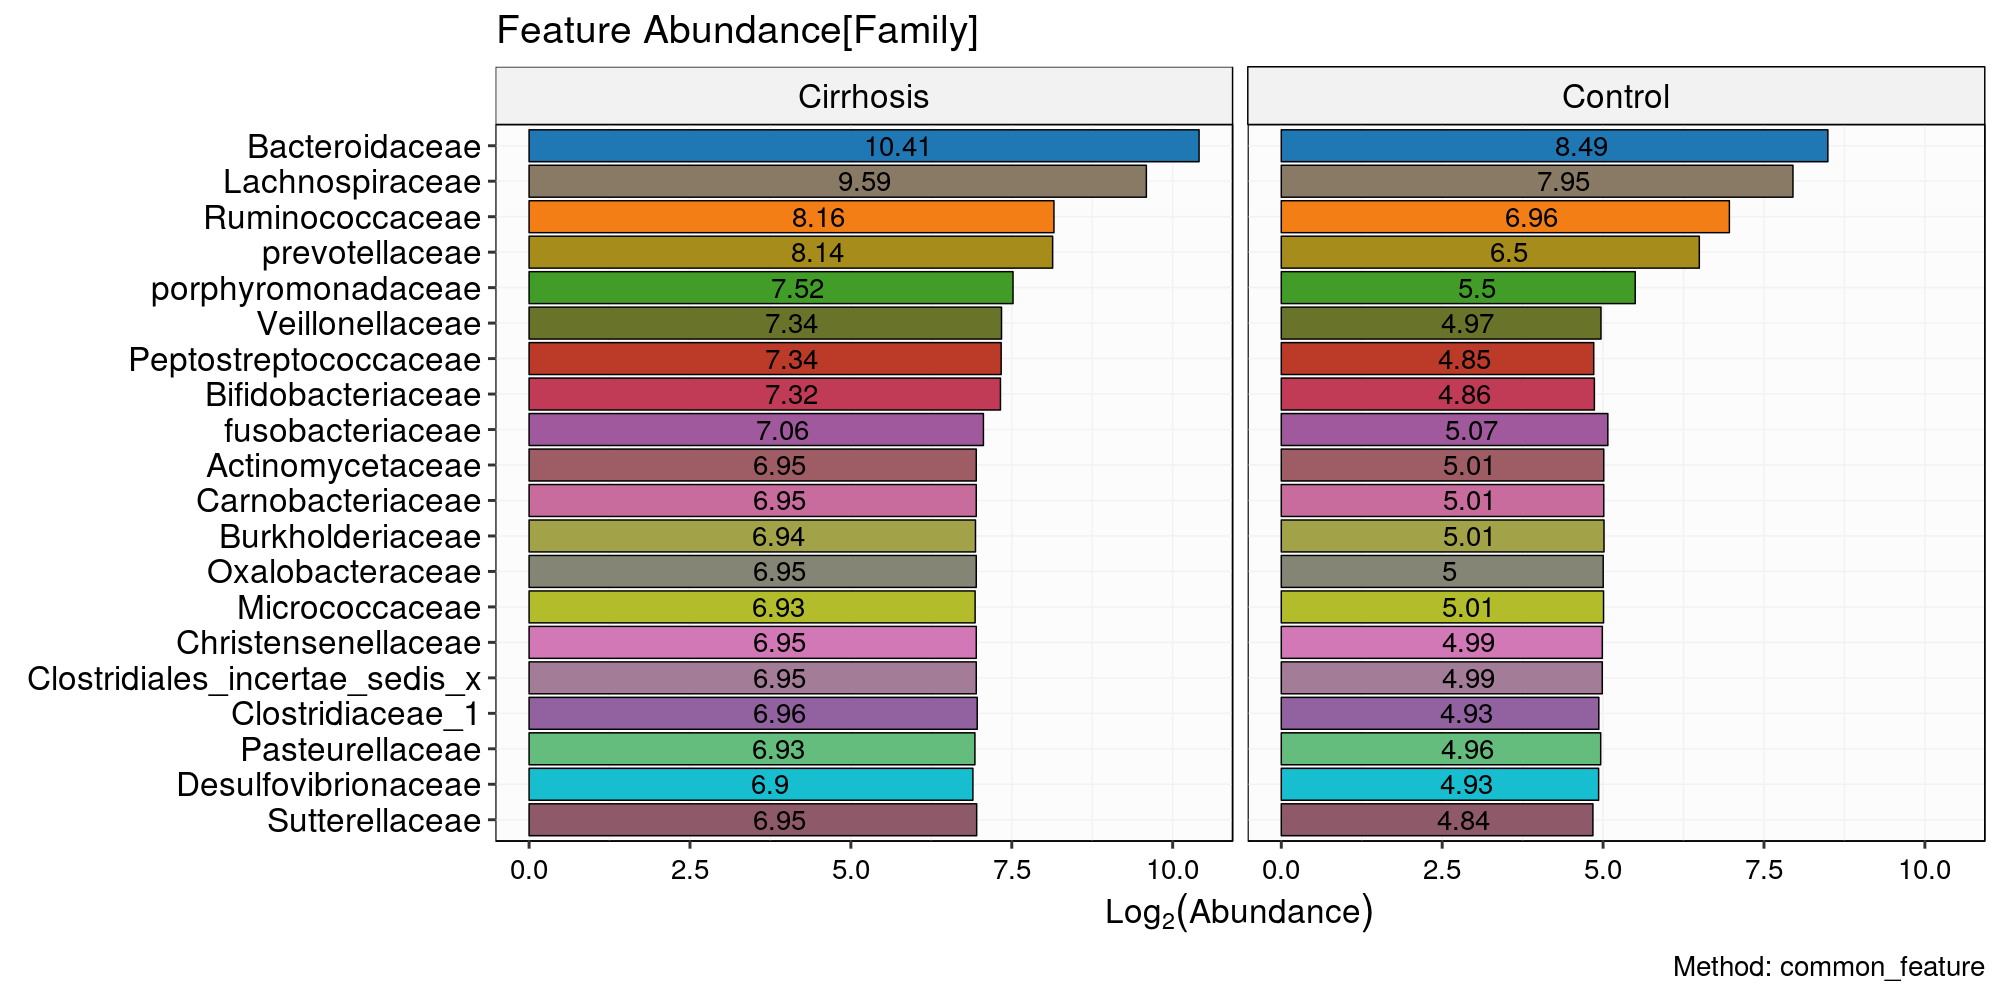

In [67]:
#####################
# Library Loading
#####################
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
library(tools)
library(ggsci)
library(scales)
library(ComplexHeatmap)
library(cowplot)
library(gplots)
library(RColorBrewer)
library(gridExtra)
library(ggrepel)
library(hrbrthemes)
######################
# SETTING
######################
args = commandArgs(trailingOnly=TRUE)
options(scipen=10000000)
PLOTLY_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
JCO_PALLETT = pal_jco("default")(10)
FEATURE_PALLETT = PLOTLY_Pallett
SAMPLE_PALLETT = c("#6A3D9A", "#FF7F00")
OFFLINE_MODE=FALSE

#OTU count limit
OTU_COUNT_LIMIT = 20


if(OFFLINE_MODE==FALSE){
    options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 200)
}
######################
# INPUT/OUTPUT
#####################
if(OFFLINE_MODE==FALSE){
    abundance_file_Path = "/data/shamsaddinisha/Test_Space/BiomMiner/VCUJas_Project_0002/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control/aggregate_abundance/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control.Family.aggregate_abundance.txt"
    metadata_file_Path = "/data/shamsaddinisha/Test_Space/BiomMiner/VCUJas_Project_0002/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control/aggregate_metadata/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control.Family.aggregate_metadata.txt"
    taxonomy_file_Path = "/data/shamsaddinisha/Test_Space/BiomMiner/VCUJas_Project_0002/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control/aggregate_annotation/16S_Saboo_Cirrhosis_VS_16S_Saboo_Control.Family.aggregate_annotation.txt"
    selected_lineage = "Family"
    the_Selection_Mode = "common_feature"
    plot_output = "./test.overview.txt"
}else{
    abundance_file_Path = args[1]
    metadata_file_Path = args[2]
    taxonomy_file_Path = args[3]
    selected_lineage = args[4]
    the_Selection_Mode = args[5]
    plot_output = args[6]
}
#####################
# READ I/O
#####################
abundance_DF = read_tsv(abundance_file_Path)
#head(abundance_DF)
#dim(abundance_DF)
metadata_DF = read_tsv(metadata_file_Path)
#head(metadata_DF)
#dim(metadata_DF)
taxonomy_DF = read_tsv(taxonomy_file_Path)
#head(taxonomy_DF)
#dim(taxonomy_DF)
####################
# Touch-Base
####################
colnames(abundance_DF)[colnames(abundance_DF)=="#OTU ID"] <- "OTU_ID"
colnames(taxonomy_DF)[colnames(taxonomy_DF)=="#OTU ID"] <- "OTU_ID"

#level_List = unlist(strsplit(level_String,','))
#print(level_List)
#
design_List = sort(unique(metadata_DF$Treatment))
#design_List = append(design_List, "common")
design_list_Length = length(design_List)

####################
#Sample ORDER/COLOR
####################
Sample_Size = length(design_List)
Sample_Order_List = design_List
Sample_Label_Dict = Sample_Order_List
names(Sample_Label_Dict) = Sample_Order_List
Sample_Order_Factor = factor(Sample_Order_List, levels=Sample_Order_List)
Sample_Color_List = SAMPLE_PALLETT[1:Sample_Size]
Sample_Color_Dict = Sample_Color_List
names(Sample_Color_Dict) = Sample_Order_List
####################
# Data Wrangling
####################


#1-gather abundance
gather_abundance_DF = abundance_DF %>% 
    gather(
    	Sample_ID, Abundance, -OTU_ID
    	)
#head(gather_abundance_DF)
#dim(gather_abundance_DF)

#2-Abundance + metadata
metadata_gather_abundance_DF = metadata_DF %>%
    inner_join(
    	gather_abundance_DF, by = c("Sample_ID" = "Sample_ID")
    	)
#head(metadata_gather_abundance_DF)
#dim(metadata_gather_abundance_DF)


taxonomy_metadata_gather_abundance_DF= metadata_gather_abundance_DF %>%
    inner_join(
        taxonomy_DF, by = c("OTU_ID" = "OTU_ID")
        )

#head(taxonomy_metadata_gather_abundance_DF)
#dim(taxonomy_metadata_gather_abundance_DF)



    
#1- select lineage
lineage_DF = taxonomy_metadata_gather_abundance_DF %>%
    #renaming each lineage to Lineage
    rename(Lineage = Annotation) %>%
    # select required column
    select(c(Treatment, Sample_ID, Lineage, Abundance))
#print(head(lineage_DF))
#print(dim(lineage_DF))



################################
#SELECT TOP FEATURE
################################

#
total_otu_count = length(unique(lineage_DF$Lineage))
if(total_otu_count <= OTU_COUNT_LIMIT){
    #
    OTU_Limit = total_otu_count 
}else{
    #
    OTU_Limit = OTU_COUNT_LIMIT
}


################################
#SCALE FEATURES : each feature will be centered to have a mean of 0 and scaled by the standard deviation of each feature
################################
scale_this <- function(x){
  (x - mean(x, na.rm=TRUE)) / sd(x, na.rm=TRUE) 
}
scaled_lineage_DF = lineage_DF %>%
    select(c(Lineage, Treatment, Abundance)) %>%
    group_by(Treatment) %>% 
    mutate(Scaled_abundance = scale_this(Abundance)) %>%
    ungroup()
head(scaled_lineage_DF)

#2- LOG2FC_DF
LOG2FC_DF = scaled_lineage_DF %>%
    select(c(Lineage, Treatment, Scaled_abundance)) %>%
    group_by(Lineage, Treatment) %>%
    summarize(Total_scaled_abundance=sum(Scaled_abundance)) %>%
    spread(Treatment, Total_scaled_abundance) %>%
    summarise(LOG2FC=round(log2(abs(get(design_List[[1]])) + 1) - log2(abs(get(design_List[[2]])) + 1), 2)) %>%
    mutate(abs_LOG2FC=abs(LOG2FC), Direction=ifelse(LOG2FC >= 0, design_List[[1]], ifelse(LOG2FC< 0 , design_List[[2]], "common")))
head(LOG2FC_DF)


#3- selected feature DF
if(the_Selection_Mode == "common_feature"){
    selected_feature_DF = LOG2FC_DF %>%
        filter(abs_LOG2FC > 0) %>%
        arrange(abs_LOG2FC) %>%
        head(OTU_Limit)
}else if(the_Selection_Mode == "distinct_feature"){
    selected_feature_DF = LOG2FC_DF %>%
        filter(abs_LOG2FC > 0) %>%
        arrange(desc(abs_LOG2FC)) %>%
        head(OTU_Limit)
}

#print(selected_feature_DF)
#print(dim(selected_feature_DF))


################################
#BUILD FEATURE ABUNDANCE DF
################################

feature_abundance_DF = scaled_lineage_DF %>%
    select(c(Lineage, Treatment, Scaled_abundance)) %>%
    group_by(Lineage, Treatment) %>%
    summarise(Total=sum(abs(Scaled_abundance)))
    
    
text_version_DF = feature_abundance_DF %>%
    spread(Treatment, Total) %>% 
    arrange(desc(get(design_List[[1]])))
#print(text_version_DF)
#print(dim(selected_feature_abundance_DF))

selected_feature_abundance_DF = feature_abundance_DF %>%
    filter(Lineage %in% selected_feature_DF$Lineage) %>%
    arrange(desc(Total))
#print(selected_feature_abundance_DF)
#print(dim(selected_feature_abundance_DF))

####################
#FEATURE ORDER/COLOR
####################
Feature_Order_List = unique(selected_feature_abundance_DF$Lineage)
Feature_List_Size = length(Feature_Order_List)
Feature_Label_Dict = Feature_Order_List
names(Feature_Label_Dict) = Feature_Order_List
Feature_Order_Factor = factor(Feature_Order_List, levels=Feature_Order_List)
if(Feature_List_Size > 10){
    Feature_Color_List = colorRampPalette(FEATURE_PALLETT)(Feature_List_Size)
}else{
    Feature_Color_List = FEATURE_PALLETT[1:Feature_List_Size]
}
Feature_Color_Dict = Feature_Color_List
names(Feature_Color_Dict) = Feature_Order_List



###########################################################
#
# GGPLOT Feature abundance
#
###########################################################

overview_feature_abundance_ggplot_Object = ggplot(data= selected_feature_abundance_DF,
    aes(x=reorder(Lineage, log2(Total + 1)), y=log2(Total + 1), fill=Lineage)) +
    geom_bar(stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    geom_text(aes(label = round(log2(Total + 1),2)), position = position_stack(vjust = 0.5), size=3.5, hjust = 0, color="black") +
    labs(title = paste("Feature Abundance[",  selected_lineage, "]", sep=""), subtitle = NULL, caption = paste("Method: ", the_Selection_Mode, sep=""), tag = NULL, x=NULL, y=expression(Log[2]("Abundance"))) +
    scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
    #scale_y_continuous(trans = log2_trans(), breaks = trans_breaks("log2", function(x) 2^x), labels = trans_format("log2", math_format(2^.x))) + 
    scale_x_discrete(labels = function(x) substr(x, start = 1, stop = 30)) +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=10, color = "black", face = "plain", angle=0, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=12, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=8, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    ) + 
    facet_wrap(~Treatment) +
    coord_flip()


######################
#EXPORTING
######################
if(OFFLINE_MODE==TRUE){
    file_extension = file_ext(plot_output)
    #
    plot_PDF = gsub(file_extension, paste("feature_abundance.plot.pdf", sep=""), plot_output)
    plot_PNG = gsub(".pdf", ".png", plot_PDF)
    plot_JPG = gsub(".pdf", ".jpg", plot_PDF)
    plot_SVG = gsub(".pdf", ".svg", plot_PDF)
    plot_TXT = gsub(".pdf", ".txt", plot_PDF)
    #
    ggsave(file=plot_PDF, device=cairo_pdf, plot=overview_feature_abundance_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=1200)
    ggsave(file=plot_PNG, device="png", plot=overview_feature_abundance_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=300)
    ggsave(file=plot_JPG, device="jpg", plot=overview_feature_abundance_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=300)
    ggsave(file=plot_SVG, device="svg", plot=overview_feature_abundance_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=72)
    write_tsv(path=plot_TXT, x=text_version_DF)
}
    

if(OFFLINE_MODE==FALSE){
        overview_feature_abundance_ggplot_Object
}

print(paste("exploratory_feature_abundance", the_Selection_Mode, ":", selected_lineage, " completed Successfully.!!!"))